**INSERT CREDITS**

# Air Quality Analytics Collaborative Framework (AQACF) API Demonstration

## Use Cases
This notebook highlits some of the analytics and visualization capabilities of AQACF with six use cases:
1. 2021 Alisal Wildfire
2. 2020 California Wildfires
3. Los Angeles ports backlog Fall 2021
4. Fireworks during 4th of July 2022 in Los Angeles county
5. Air Pollution in the Yellow Sea
6. Fires and Thermal Anomalies in Southeast Asia in 2022

## Libraries and Functions

### Libraries
The following libraries are needed to support this notebook

In [1]:
# Libraries
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Polygon
from shapely.geometry import box
import time 
import xarray as xr
import numpy as np
from typing import List

from datetime import datetime, timedelta
from tabulate import tabulate

from IPython.display import Image
from owslib.util import Authentication
from owslib.wms import WebMapService
from PIL import Image as I
from PIL import ImageDraw

import ideas_modules.plotting as plotting
import ideas_modules.ideas_processing as ideas_processing
import xml.etree.ElementTree as xmlet

### Functions
The following functions are needed to support this notebook

In [2]:
# Default values
DEFAULT_BASEMAP_RANGE = {
    'llcrnrlon': -180,
    'llcrnrlat': -90,
    'urcrnrlon': 180,
    'urcrnrlat': 90
}
dt_format = "%Y-%m-%dT%H:%M:%SZ"
units = {
    'pm25': 'µg/m³',
    'O3': 'mol m-2',
    'SO2': 'mmol/m2',
    'NO2': 'umol/m2',
    'CO': 'ppb',
    'CH4': 'ppb'
}
url_in_situ            = 'https://ideas-digitaltwin.jpl.nasa.gov/insitu/1.0'
endpoint_in_situ       = 'query_data_doms'
start_index_in_situ    = 0
items_per_page_in_situ = 500

In [3]:

def spatial_mean(base_url, dataset, bb, start_time, end_time, proc=[]):
    url = '{}/timeSeriesSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}&lowPassFilter=False&seasonalFilter=False'.\
        format(base_url, dataset, bb['min_lon'], bb['min_lat'], bb['max_lon'], bb['max_lat'],
               start_time.strftime(dt_format), end_time.strftime(dt_format))

    # Display some information about the job
    print(url); print()

    # Query SDAP to compute the time averaged map
    print("Waiting for response from SDAP...")
    start = time.perf_counter()
    ts_json = requests.get(url, verify=False).json()
    print("Time series took {} seconds".format(time.perf_counter() - start))
    return prep_ts(ts_json, proc)

def prep_ts(ts_json, proc):
    shortname = ts_json['meta'][0]['shortName']
    time = np.array([np.datetime64(ts[0]["iso_time"][:10]) for ts in ts_json["data"]])
    vals = np.array([ts[0]["mean"] for ts in ts_json["data"]])
    
    da = xr.DataArray(vals, coords = [time], dims=['time'])
    
    for proc in proc:
        da = proc(da)
        
    da.attrs['shortname'] = shortname
        
    return da

def calc_anoms(data):
    return data - np.nanmean(data)

def comparison_plot(data, x_label, y_label, var='', anoms=False):
    plt.figure(figsize=(15,6))
    
    for da in data:
        if anoms:
            vals = calc_anoms(da.values)
        else:
            vals = da.values
        plt.plot(da.time, vals, linewidth=2, label=da.attrs['shortname'])
    
    plt.grid(b=True, which='major', color='k', linestyle='-')
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel (y_label, fontsize=12)
    plt.xticks(rotation=45)
    plt.title(f'{var}{" Anomalies" if anoms else ""}', fontsize=16)
    plt.legend(prop={'size': 12})
    plt.show()
    
def temporal_variance(base_url, dataset, bb, start_time, end_time):
    params = {
        'ds': dataset,
        'minLon': bb['min_lon'],
        'minLat': bb['min_lat'],
        'maxLon': bb['max_lon'],
        'maxLat': bb['max_lat'],
        'startTime': start_time.strftime(dt_format),
        'endTime': end_time.strftime(dt_format)
    }
    
    url = '{}/varianceSpark?ds={}&minLon={}&minLat={}&maxLon={}&maxLat={}&startTime={}&endTime={}'.\
        format(base_url, dataset, bb['min_lon'], bb['min_lat'], bb['max_lon'], bb['max_lat'],
               start_time.strftime(dt_format), end_time.strftime(dt_format))
    
    # Display some information about the job
    print(url); print()
    
    # Query SDAP to compute the time averaged map
    print("Waiting for response from SDAP...")
    start = time.perf_counter()
    var_json = requests.get(url, params=params, verify=False).json()
    print("Time series took {} seconds".format(time.perf_counter() - start))
    return prep_var(var_json)
    
def prep_var(var_json):
    shortname = var_json['meta']['shortName']

    vals = np.array([v['variance'] for var in var_json['data'] for v in var])
    lats = np.array([var[0]['lat'] for var in var_json['data']])
    lons = np.array([v['lon'] for v in var_json['data'][0]])
    
    vals[vals==-9999]=np.nan
    
    vals_2d = np.reshape(vals, (len(var_json['data']), len(var_json['data'][0])))

    da = xr.DataArray(vals_2d, coords={"lat": lats, "lon": lons}, dims=["lat", "lon"])
    da.attrs['shortname'] = shortname
    da.attrs['units'] = '$m^2/s^2$'
    return da

def get_in_situ_data(start_time: str, end_time: str,
                     min_lon: int, max_lon: int, min_lat: int, max_lat: int, provider: str) -> pd.DataFrame:
    data = []
    query_url = f'{url_in_situ}/{endpoint_in_situ}?' \
                f'startIndex={start_index_in_situ}&itemsPerPage={items_per_page_in_situ}&' \
                f'startTime={start_time}&endTime={end_time}&' \
                f'bbox={min_lon},{min_lat},{max_lon},{max_lat}&' \
                f'provider={provider}'
    if query_url:
        print(query_url)
    while query_url:
        resp = requests.get(query_url, verify=False).json()
        if len(resp['results']):
            data += resp['results']
        query_url = resp['next'].replace('http:', 'https:') if resp['last'] != resp['next'] else None

    
    return pd.DataFrame(data) if len(data) else None

def stacked_overlay_plot(x_datas: List[np.array], y_datas: List[np.array],
                series_labels: List[str], y_labels=List[str], title: str='',
                top_paddings: List[int]=[0, 0]):

    plt.style.use('ggplot')
    fig, ax = plt.subplots(2, 1, sharex=True)

    # Plot 1
    ax[0].set_title(title)
    ax[0].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[0] ],
        y_datas[0], label=series_labels[0])
        
    # Plot 2
    ax[0].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[1] ],
        y_datas[1], label=series_labels[1])

    ax[0].legend(loc='upper center', shadow=True)
    y_data_max = max( np.amax(y_datas[0]), np.amax(y_datas[1]) )
    ax[0].set_ylim([ 0, y_data_max + top_paddings[0] ])
    ax[0].set_ylabel(y_labels[0])

    # Plot 3
    ax[1].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[2] ],
        y_datas[2], label=series_labels[2])
        
    # Plot 4
    ax[1].plot(
        [ datetime.strptime(x_val, '%Y-%m-%dT%H:%M:%SZ').replace(year=2022) for x_val in x_datas[3] ],
        y_datas[3], label=series_labels[3])
    
    ax[1].legend(loc='upper center', shadow=True)
    y_data_max = max(np.amax(y_datas[2]), np.amax(y_datas[3]))
    ax[1].set_ylim([ 0, y_data_max + top_paddings[1] ])
    ax[1].set_ylabel(y_labels[1])

    # Set title and legend
    plt.legend(loc='upper center', shadow=True)

    # Set grid and ticks
    dtFmt = mdates.DateFormatter('%b %d')
    plt.gca().xaxis.set_major_formatter(dtFmt)
    plt.xticks(rotation=45)
    ax[0].tick_params(left=False, bottom=False)
    ax[1].tick_params(left=False, bottom=False)
    ax[0].grid(b=True, which='major', color='k', linestyle='--', linewidth=0.25)
    ax[1].grid(b=True, which='major', color='k', linestyle='--', linewidth=0.25)
    
    plt.show()

## AQACF DATA Inventory

In [4]:
aq_base_url = 'https://ideas-digitaltwin.jpl.nasa.gov/nexus/'
r = requests.get(f'{aq_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
inv_df.sort_values('title')

title  \
0    3IMERGHHE_06_precipitationCal_Parkistan_202207...   
1                     GLDAS_VIC10_3H_2_1_global_Qs_acc   
2                    GLDAS_VIC10_3H_2_1_global_Qsb_acc   
3                               GPM-3IMERGHHE-05-daily   
4                                GPM-3IMERGHHE-06-dail   
..                                                 ...   
606  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
607    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D8   
608  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   
609    wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D9   
610  wustl-0.1degx0.1deg-daily-ca-SpeciesConc_SO2_D...   

                    iso_start                   iso_end  
0    2022-07-01T00:00:00+0000  2022-09-02T14:30:00+0000  
1    2019-02-14T00:00:00+0000  2021-03-01T21:00:00+0000  
2    2019-02-14T00:00:00+0000  2021-03-01T21:00:00+0000  
3    2016-11-01T00:00:00+0000  2018-12-31T00:00:00+0000  
4    2019-10-12T00:00:00+0000  2019-10-12T00:00:00+0000  
..                        ...                       ...  
606  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
607  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
608  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  
609  2017-03-01T12:00:00+0000  2018-12-31T12:00:00+0000  
610  1970-01-01T00:00:00+0000  1970-12-01T00:00:00+0000  

[611 rows x 3 columns]

In [5]:
# querying data
gmu_base_url = "https://aq-sdap.stcenter.net/nexus/"
r = requests.get(f'{gmu_base_url}/list', verify=False).json()
inv_df = pd.DataFrame(r)[['title', 'iso_start', 'iso_end']].dropna(how='all')
titles = inv_df.sort_values('title')
for title in titles.values:
    if (title[1]<='2020-01-01' and title[2]>='2020-12-31'):
        print(title)

['OMI-0.05deg-war-weekly-UA-Aerosol' '2012-01-07T00:00:00+0000'
 '2022-10-28T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-NO2' '2012-01-07T00:00:00+0000'
 '2022-11-25T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-O3' '2012-01-07T00:00:00+0000'
 '2022-11-11T00:00:00+0000']
['OMI-0.05deg-war-weekly-UA-SO2' '2012-01-28T00:00:00+0000'
 '2022-10-28T00:00:00+0000']
['OMI-0.05deg-weekly-UA-NO2' '2012-01-01T00:00:00+0000'
 '2022-08-28T00:00:00+0000']
['OMI-0.25deg-monthly-Global-NO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-O3' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['OMI-0.25deg-monthly-Global-SO2' '2004-10-01T00:00:00+0000'
 '2022-09-01T00:00:00+0000']
['PM25' '2018-01-01T15:00:00+0000' '2021-12-31T23:00:00+0000']
['TROPOMI-0.1deg-GMU-CA-NO2' '2018-09-01T00:00:00+0000'
 '2020-12-31T00:00:00+0000']


# 2021 Alisal Wildfire

For much of summer 2021, large fires decimated forests in Northern California. By the middle of October, those fires were mostly extinguished or burned out, but red-flag warnings and fierce fires had begun to cause problems in the chaparral shrublands and grasslands of Central and Southern California.

After igniting near the Alisal reservoir on October 11, the fast-moving blaze charred 13,400 acres (54 square kilometers) by the afternoon of October 13. At that time, the fire was 5 percent contained. With the blaze threatening at least 100 structures, authorities issued evacuation orders and closed parts of Highway 101. The fire was designated as fully contained on Sep. 20, 2021 with a total burn time of 39 days.

In addition to destroying natural habitats wildfires emit high levels of Sulfur Dioxide (SO2) and Nitrogen Dioxide (NO2) while also destroying Ozone (O3) levels.

### Area of Interest

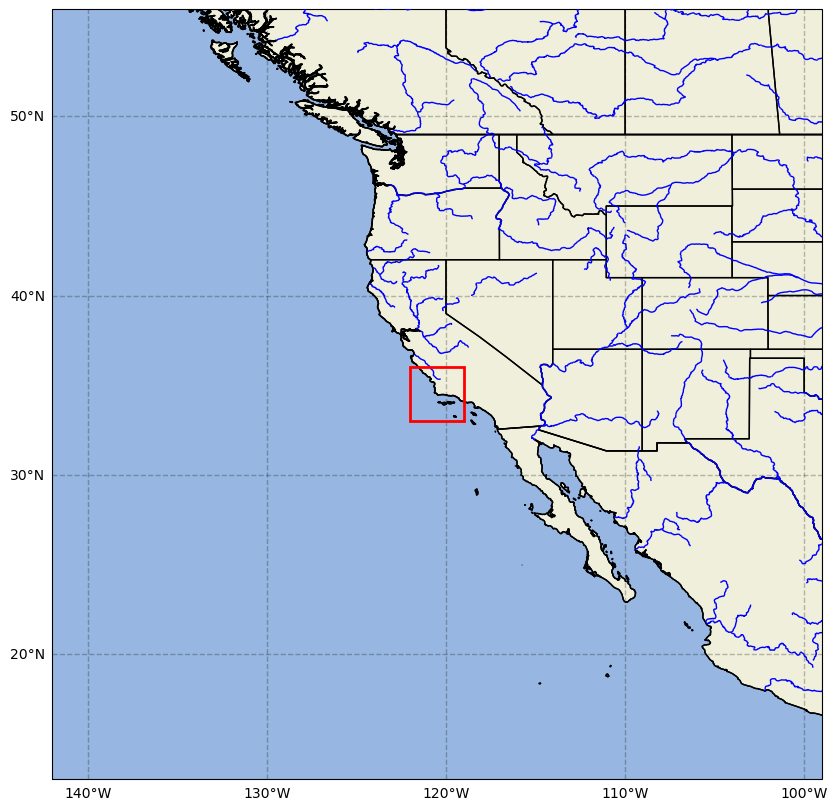

In [6]:
wildfires_bb = {'min_lon': -122, 'max_lon': -119, 'min_lat': 33, 'max_lat': 36}
wildfires_start_time = datetime(2020,8,1)
wildfires_end_time = datetime(2020,11,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)

### Alisal Smoke Plume Visualization
On October 13, 2021, the Moderate Resolution Imaging Spectroradiometer (MODIS) on NASA’s Aqua satellite captured this image of the Alisal fire northwest of Santa Barbara. Strong northerly winds pushed plumes of smoke over the Pacific Ocean. 

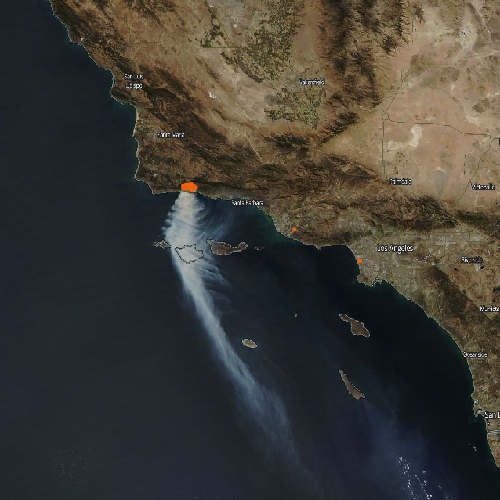

In [7]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Aqua_CorrectedReflectance_TrueColor',
                         'MODIS_Aqua_Thermal_Anomalies_All',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(-122,32,-117,36),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2021-10-12',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image
Image(img.read()) # NOTE add in rest of tropomi data, add a time lapse gif of the fire plume 

In [8]:
alisal_bb = {'min_lon': -120.559662, 'max_lon': -120.179261, 'min_lat': 34.308912, 'max_lat': 34.660953}
alisal_start_time = datetime(2021,10,1)
alisal_end_time = datetime(2021,12,1)

### NO2 Levels

Wildfires are a significant source of nitrogen oxides (NOx ≡ NO + NO2) to the global atmosphere, representing approximately 15% of the total NOx budget.

The graph below shows the NO2 output lifecycle of the Alisal wildfire (burned 10-11-2021 through 11-20-2021).

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=OMI-0.25deg-monthly-Global-NO2&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-12-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 5.383061619009823 seconds


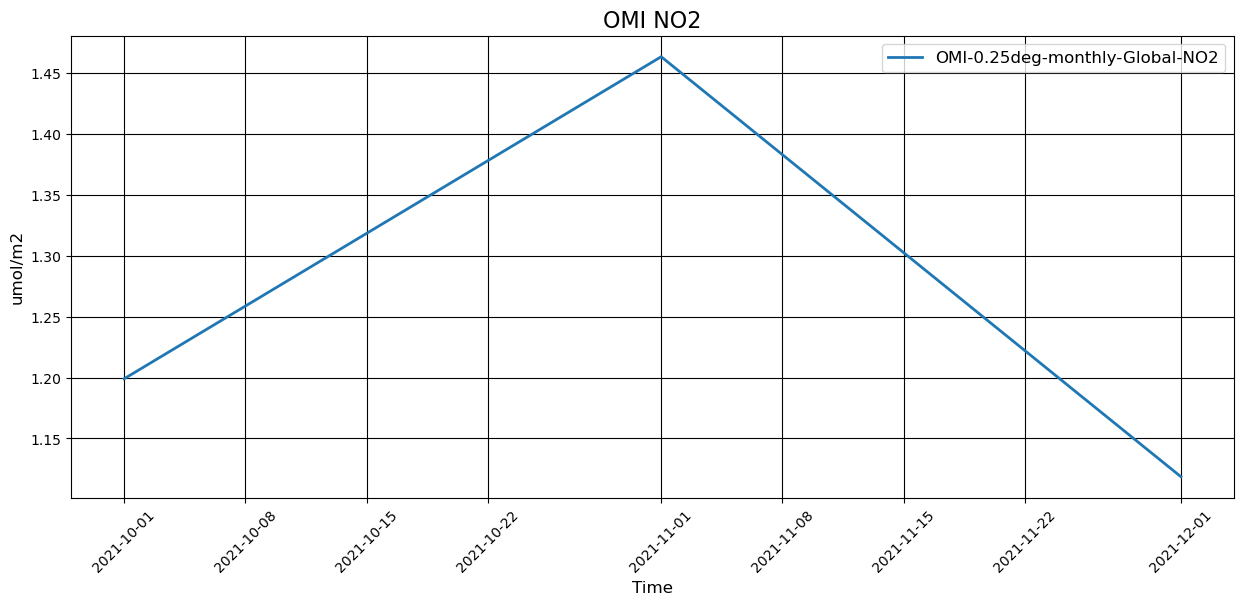

In [9]:
wildfires_omi_no2 = spatial_mean(gmu_base_url, 'OMI-0.25deg-monthly-Global-NO2', alisal_bb, alisal_start_time, alisal_end_time)
comparison_plot([wildfires_omi_no2], 'Time', units['NO2'], var='OMI NO2')

### O3 Levels

Wildfires harm the ozone layer by depleting Ozone levels putting us at an increased risk from ultraviolet (UV) radiation. 
Researchers caution that if major fires become more frequent with a changing climate, more damaging ultraviolet radiation from the sun will reach the ground.

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=OMI-0.25deg-monthly-Global-O3&minLon=-120.559662&minLat=34.308912&maxLon=-120.179261&maxLat=34.660953&startTime=2021-10-01T00:00:00Z&endTime=2021-12-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.0433433039870579 seconds


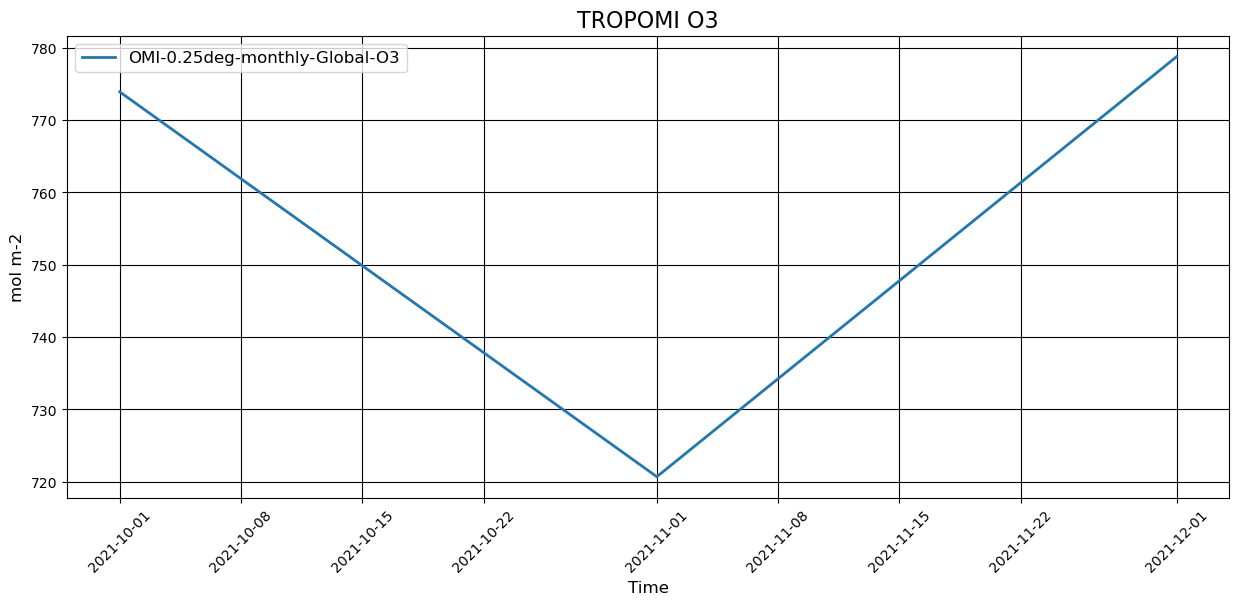

In [10]:
wildfires_omi_O3 = spatial_mean(gmu_base_url, 'OMI-0.25deg-monthly-Global-O3', alisal_bb, alisal_start_time, alisal_end_time)
comparison_plot([wildfires_omi_O3], 'Time', units['O3'], var='TROPOMI O3')

# 2020 California Wildfires 
The 2020 California wildfire season was one of the worst on record with about 4.3 million acres burned.
It's estimated that California’s 2020 wildfire emissions were akin to 24 million cars.


### Area of Interest

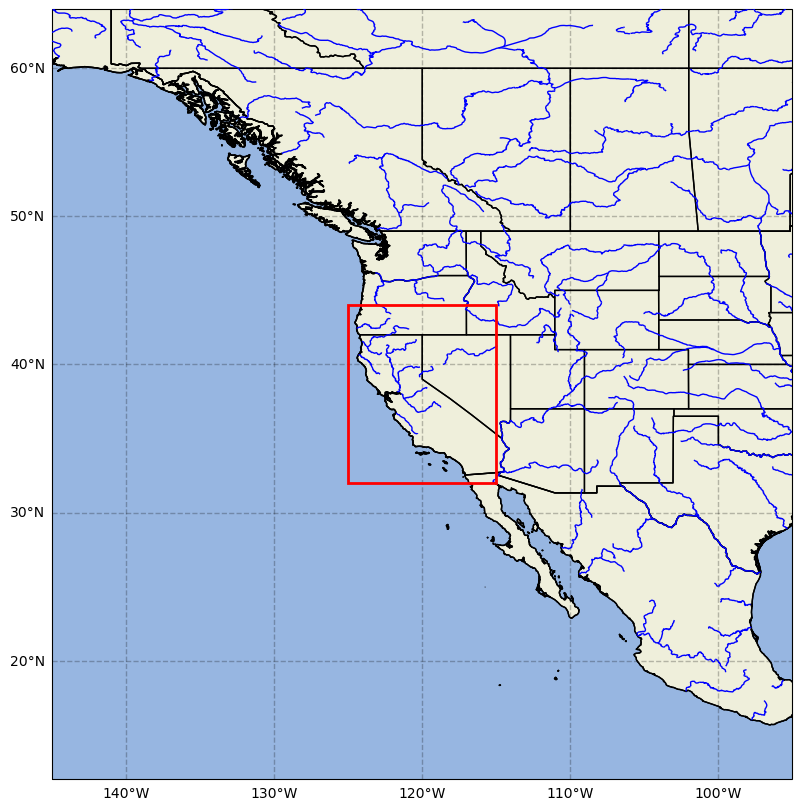

In [11]:
wildfires_bb = {'min_lon': -125, 'max_lon': -115, 'min_lat': 32, 'max_lat': 44}
wildfires_start_time = datetime(2020,8,1)
wildfires_end_time = datetime(2020,11,1)

wildfires_bbox = box(wildfires_bb['min_lon'], wildfires_bb['min_lat'], wildfires_bb['max_lon'], wildfires_bb['max_lat'])
plotting.map_box(wildfires_bb)


### SO2 Levels
Sulfur dioxide (SO2) is a foul-smelling toxic gas which can damage trees and plants, inhibit plant growth, and damage sensitive ecosystems and waterways. It also can contribute to respiratory illness and aggravate existing heart and lung conditions.

Additionally sulfur dioxide can create secondary pollutants, such as sulfate aerosols, particulate matter, and acid rain, once released into the air.

In [12]:
tropomi_so2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 4.0287691639969125 seconds


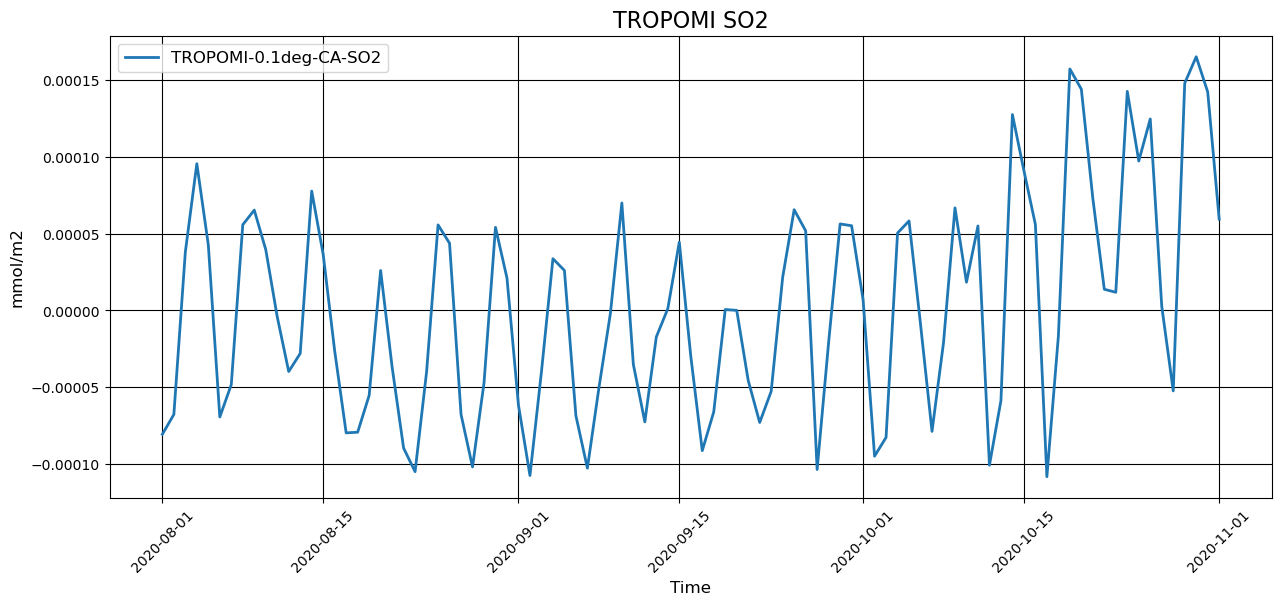

In [13]:
comparison_plot([tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

### O3 Levels

In [14]:
tropomi_o3 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.9006771209824365 seconds


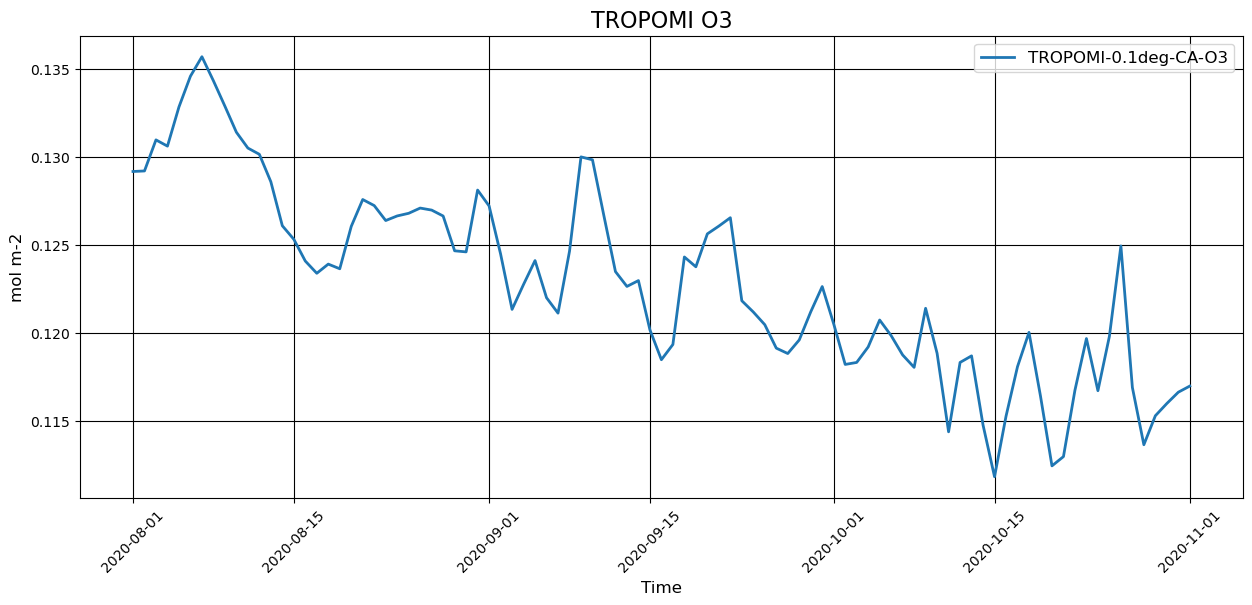

In [15]:
comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

### NO2 Levels

https://aq-sdap.stcenter.net/nexus//timeSeriesSpark?ds=OMI-0.25deg-monthly-Global-NO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 1.2897192539821845 seconds


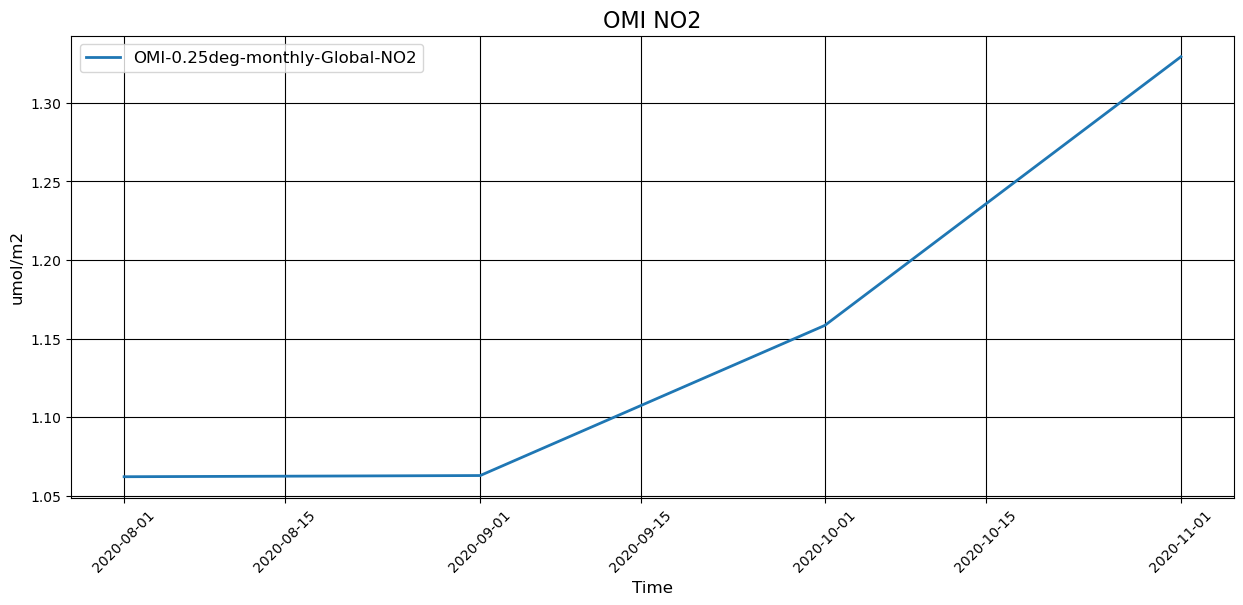

In [16]:
wildfires_omi_no2 = spatial_mean(gmu_base_url, 'OMI-0.25deg-monthly-Global-NO2', wildfires_bb, wildfires_start_time, wildfires_end_time)
comparison_plot([wildfires_omi_no2], 'Time', units['NO2'], var='OMI NO2')

### SO2 Temporal Variance

In [17]:
wildfires_temp_var_tropomi_so2 = temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z

Waiting for response from SDAP...
Time series took 3.9191084260237403 seconds


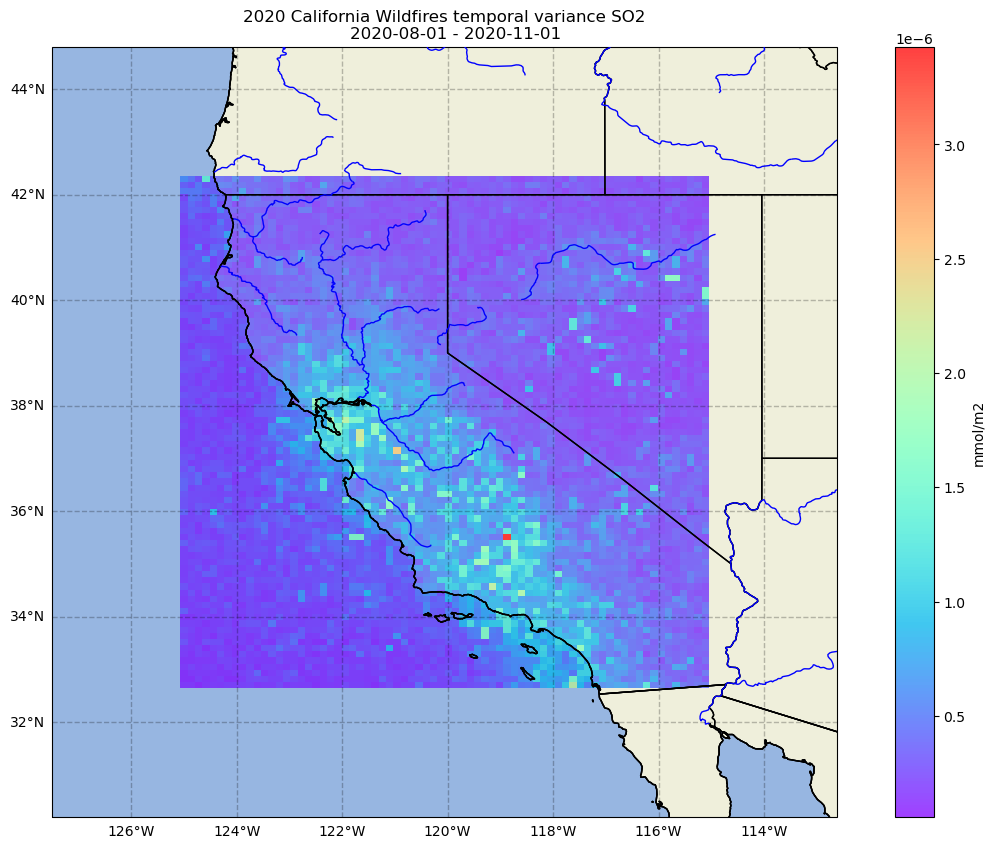

In [18]:
wildfire_variance_title = f'2020 California Wildfires temporal variance SO2\n\
    {str(wildfires_start_time)[:10]} - {str(wildfires_end_time)[:10]}'
plotting.map_data(wildfires_temp_var_tropomi_so2, wildfire_variance_title, cb_label=units['SO2'])

### O3 Temporal Variance

In [19]:
wildfires_temp_var_tropomi_o3 = temporal_variance(aq_base_url, 'TROPOMI-0.1deg-CA-O3', wildfires_bb, wildfires_start_time, wildfires_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//varianceSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-125&minLat=32&maxLon=-115&maxLat=44&startTime=2020-08-01T00:00:00Z&endTime=2020-11-01T00:00:00Z

Waiting for response from SDAP...
Time series took 4.042843592993449 seconds


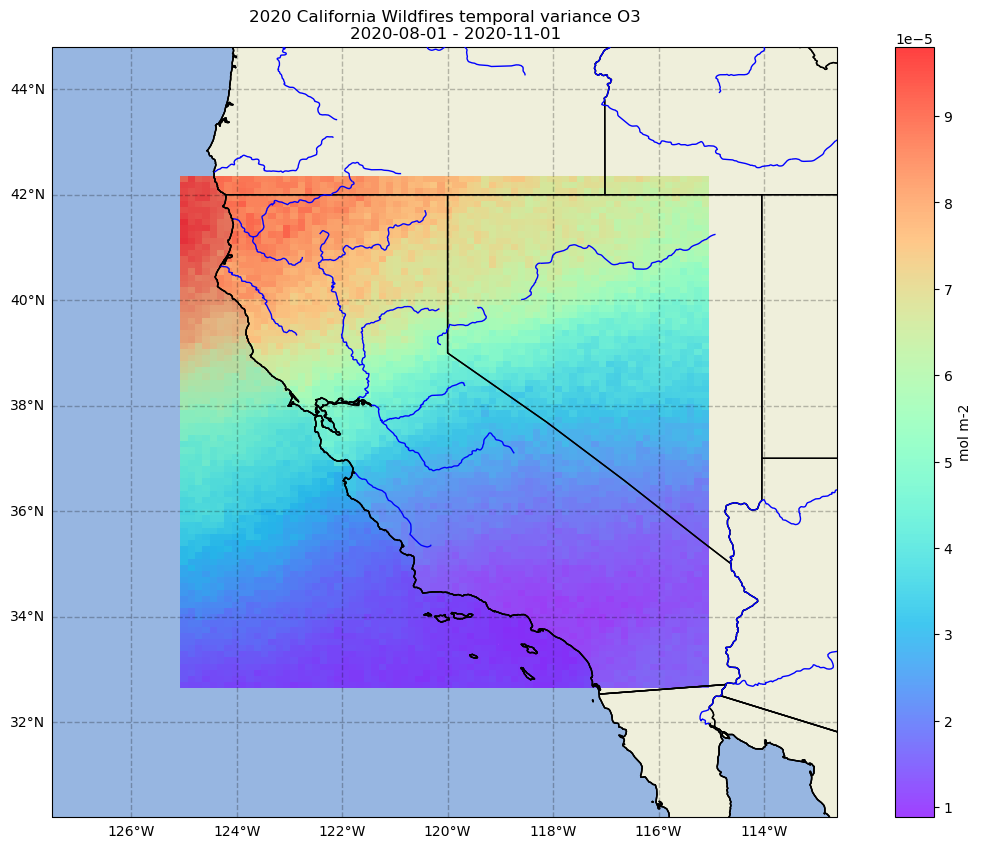

In [20]:
wildfire_variance_title = f'2020 California Wildfires temporal variance O3\n\
    {str(wildfires_start_time)[:10]} - {str(wildfires_end_time)[:10]}'
plotting.map_data(wildfires_temp_var_tropomi_o3, wildfire_variance_title, cb_label=units['O3'])

# Los Angeles ports backlog Fall 2021
Beginning around October 2021, the Ports of Los Angeles and Long Beach started suffering serious backlogs of ships due a surge in e-commerence because of the COVID-19 pandemic. This resulted in many ships anchored in the ports and releasing high amounts of pollutants. 

### Area of interest

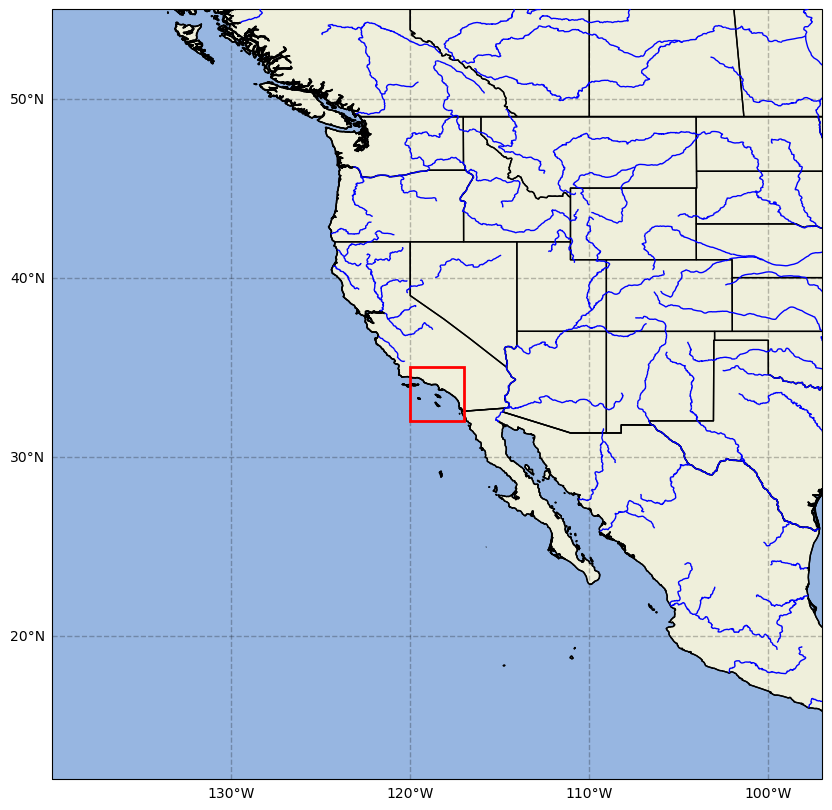

In [21]:
la_ports_bb = {
    'min_lon': -120,
    'max_lon': -117,
    'min_lat': 32,
    'max_lat': 35
}
la_ports_basemap_range = {
    'llcrnrlon': -140,
    'llcrnrlat': 0,
    'urcrnrlon': -90,
    'urcrnrlat': 60
}

la_ports_start_time = datetime(2021,10,1)
la_ports_end_time = datetime(2021,12,31)

la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### SO2 Levels

In [22]:
la_ports_tropomi_so2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-SO2', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-SO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.44727525298367254 seconds


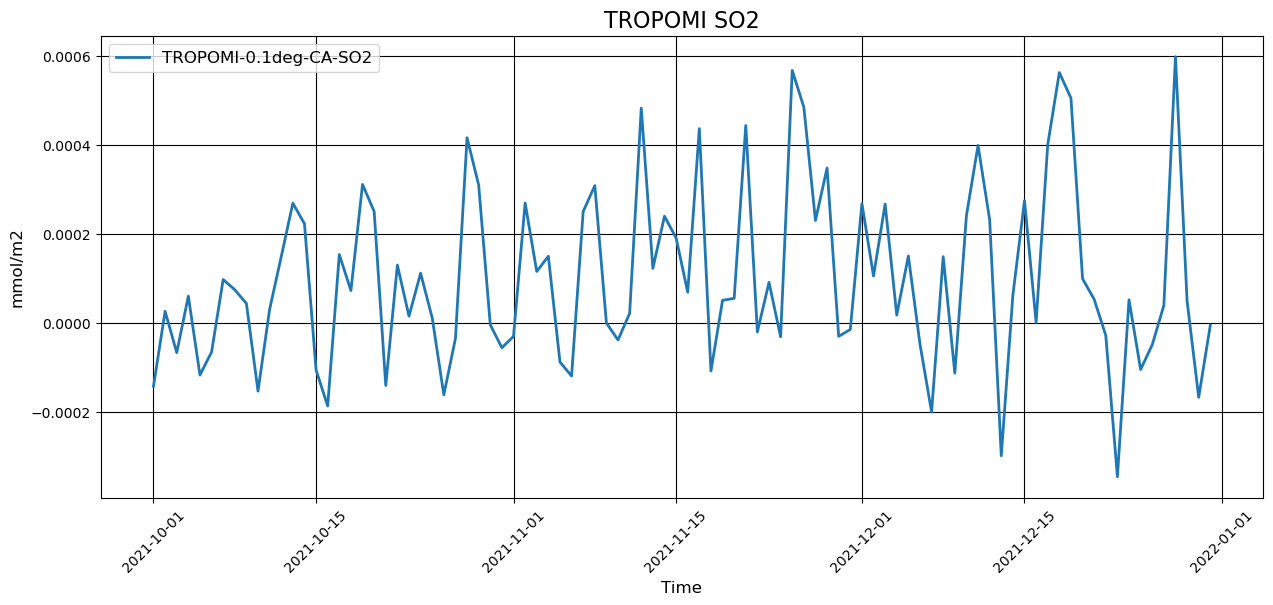

In [23]:
comparison_plot([la_ports_tropomi_so2], 'Time', units['SO2'], var='TROPOMI SO2')

### O3 Levels

In [24]:
tropomi_o3 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-O3', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-O3&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.5246012230054475 seconds


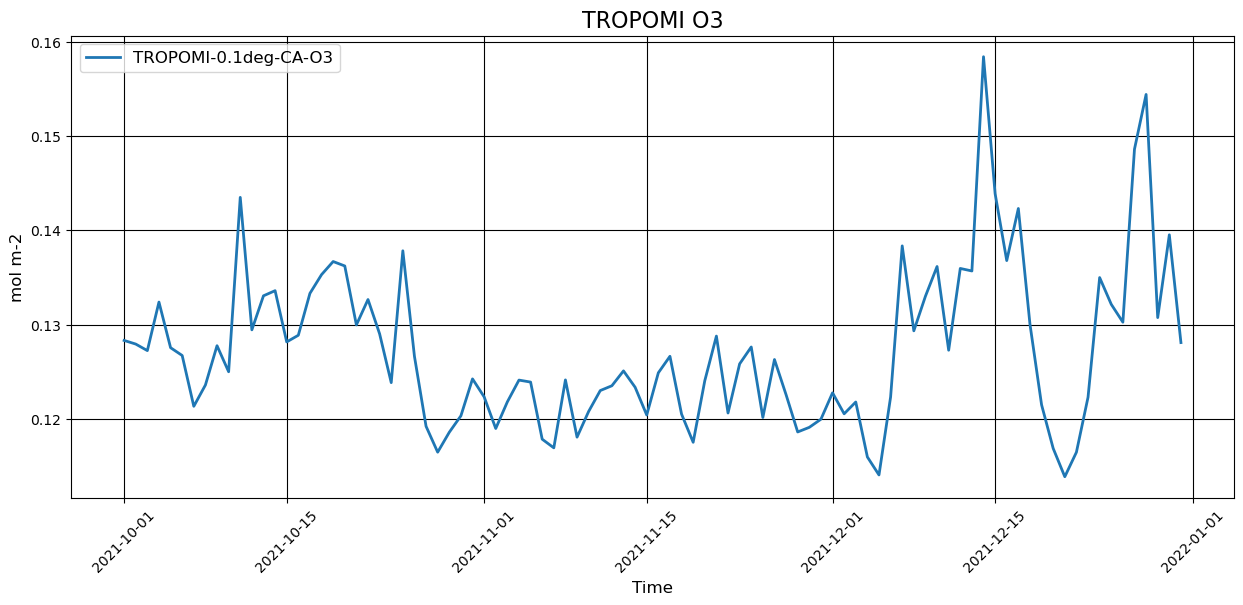

In [25]:
comparison_plot([tropomi_o3], 'Time', units['O3'], var='TROPOMI O3')

### NO2 Levels

In [26]:
tropomi_no2 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-NO2', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-NO2&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.41450322201126255 seconds


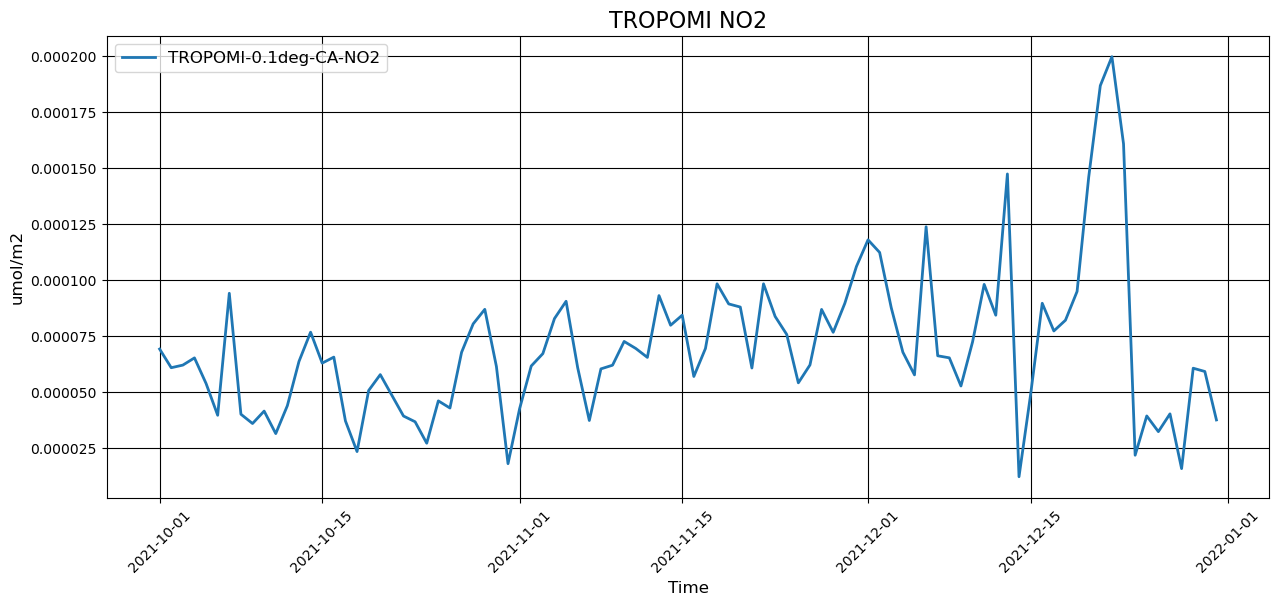

In [27]:
comparison_plot([tropomi_no2], 'Time', units['NO2'], var='TROPOMI NO2')

### CO Levels

In [28]:
tropomi_co = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CO', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CO&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.28634236499783583 seconds


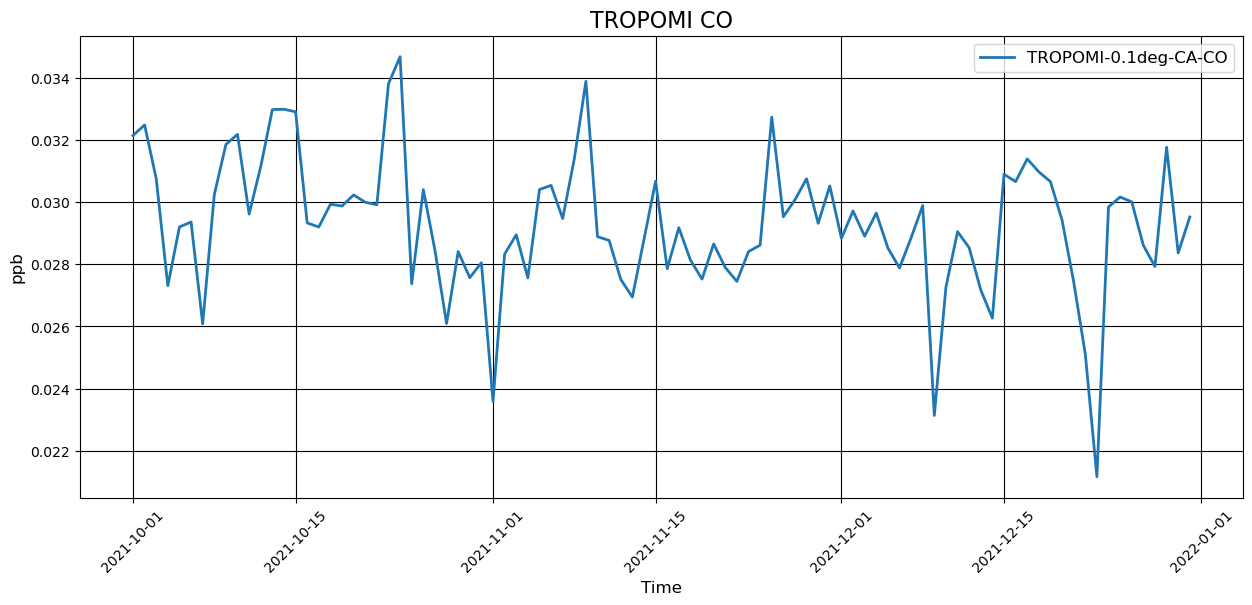

In [29]:
comparison_plot([tropomi_co], 'Time', units['CO'], var='TROPOMI CO')

### CH4 Levels

Ships use methane (CH4) in the form of liquified natural gas. Remote marine air-quality measurements have shown significant methane emissions from ships using liquefied natural gas as a fuel.

In [30]:
tropomi_ch4 = spatial_mean(aq_base_url, 'TROPOMI-0.1deg-CA-CH4', la_ports_bb, la_ports_start_time, la_ports_end_time)

https://ideas-digitaltwin.jpl.nasa.gov/nexus//timeSeriesSpark?ds=TROPOMI-0.1deg-CA-CH4&minLon=-120&minLat=32&maxLon=-117&maxLat=35&startTime=2021-10-01T00:00:00Z&endTime=2021-12-31T00:00:00Z&lowPassFilter=False&seasonalFilter=False

Waiting for response from SDAP...
Time series took 0.302075148007134 seconds


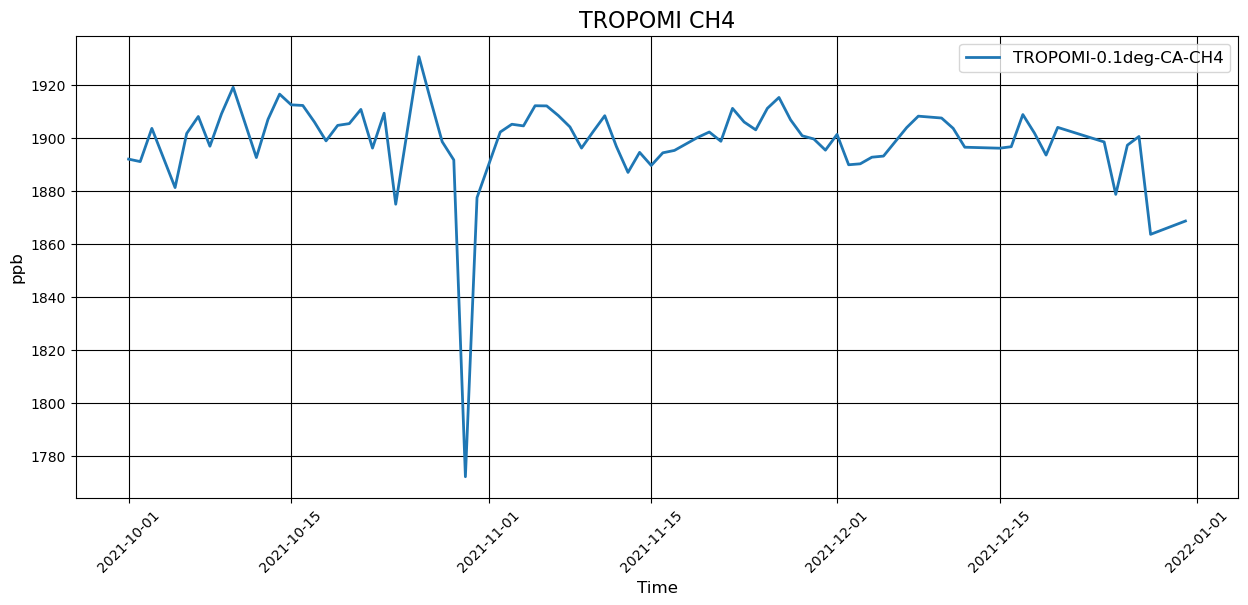

In [31]:
comparison_plot([tropomi_ch4], 'Time', units['CH4'], var='TROPOMI CH4')

# Fireworks during 4th of July 2022 in Los Angeles County
Despite fireworks being outlawed for personal use in Los Angeles County, there is a significant amount of illegal fireworks displays in the area around 4th of July that cause very smoggy conditions.  
Below we model our in situ Particulate matter 2.5 and Black Carbon data from around 4th of July 

### Area of Interest

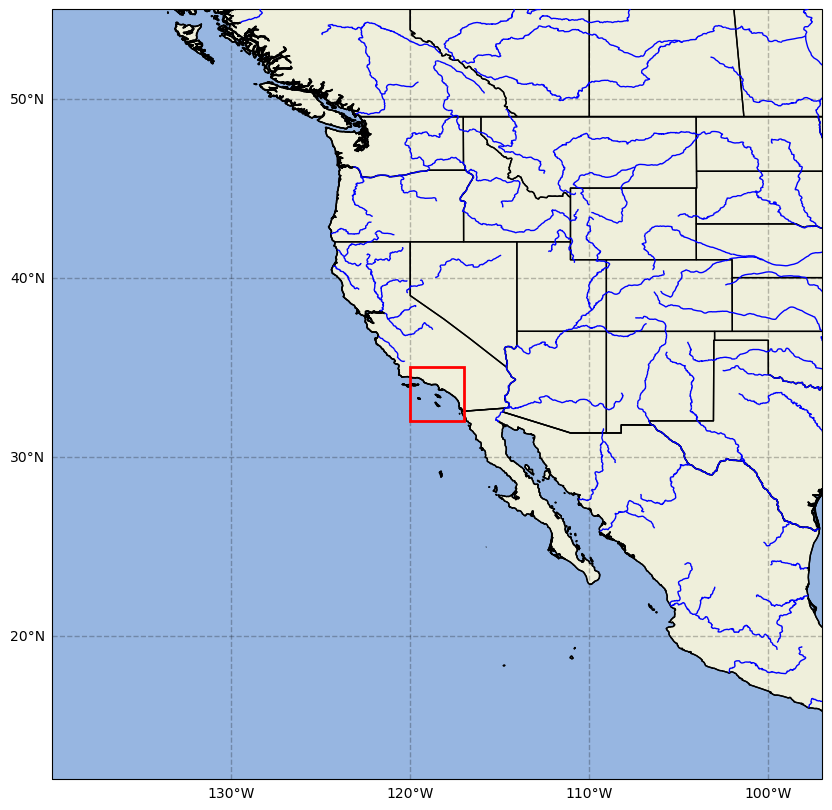

In [32]:
la_ports_bbox = box(la_ports_bb['min_lon'], la_ports_bb['min_lat'], la_ports_bb['max_lon'], la_ports_bb['max_lat'])
plotting.map_box(la_ports_bb)

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2021-06-28 to 2021-07-11)

In [ ]:
# NOTE: this enpoint sometimes doesn't work, worked yesterday but doesn't work today

start_time_fireworks      = '2021-06-28T00:00:00Z'
end_time_fireworks        = '2021-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2021_fireworks  = get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2021_fireworks 

### Get PM 2.5 and Black Carbon (BC) from B301 GRIMM Aethalometer (2022-06-28 to 2022-07-11)

In [ ]:
start_time_fireworks      = '2022-06-28T00:00:00Z'
end_time_fireworks        = '2022-07-11T00:00:00Z'
min_lon_fireworks         = -120
max_lon_fireworks         = -115
min_lat_fireworks         = 30
max_lat_fireworks         = 40
provider_fireworks        = 'B301-GRIMM-Aethalometer'

pm25_bc_2022_fireworks  = get_in_situ_data(start_time_fireworks, end_time_fireworks,
                        min_lon_fireworks, max_lon_fireworks, min_lat_fireworks, max_lat_fireworks, provider_fireworks)
pm25_bc_2022_fireworks 

## Compare 2021 and 2022 emissions 
Unlike last year, PM2.5 levels showed only a minor elevation during the night of July 4th. However, a large peak (up to 100 µg/m3) was observed during the morning of July 5th, comparable to the levels measured last year, most likely due to the transport of smoke from South/Central LA.

As expected, Black Carbon (BC) levels did not show an appreciable increase during the fireworks event. Fireworks do not emit very large amounts of BC relative to other species. Organic and inorganic aerosols (particularly metals) dominate emissions from fireworks. A PM2.5 sample was collected, using the Aerosol Mass and Optical Depth (AMOD) instrument, for chemical analysis which includes X-ray fluorescence (XRF) spectroscopy for detection of metals.

In [ ]:
time_2021_fireworks = np.array(pm25_bc_2021_fireworks['time'])
pm25_2021_fireworks = np.array(pm25_bc_2021_fireworks['pm2_5'])
bc_2021_fireworks   = np.array(pm25_bc_2021_fireworks['bc'])

time_2022_fireworks = np.array(pm25_bc_2022_fireworks['time'])
pm25_2022_fireworks = np.array(pm25_bc_2022_fireworks['pm2_5'])
bc_2022_fireworks   = np.array(pm25_bc_2022_fireworks['bc'])

In [ ]:
y_datas = [ pm25_2021_fireworks, pm25_2022_fireworks, bc_2021_fireworks, bc_2022_fireworks ]
x_datas = [ time_2021_fireworks, time_2022_fireworks, time_2021_fireworks, time_2022_fireworks ]
series_labels = [ 'PM 2.5 emission (2021)', 'PM 2.5 emission (2022)', 
                  'Black Carbon emission (2021)', 'Black Carbon emission (2022)' ]
y_labels = [ 'GRIMM PM 2.5 (µg/m³)', 'BC (µg/m³)' ]

stacked_overlay_plot(x_datas=x_datas, y_datas=y_datas, series_labels=series_labels,
                       y_labels=y_labels, title='Compare 2021 and 2022 emissions', top_paddings=[80, 2])

# Air Pollution in the Yellow Sea

The Yellow Sea is a marginal sea of the Western Pacific Ocean located between mainland China and the Korean Peninsula. It is considered among the most degraded marine areas on earth. Loss of natural coastal habitats due to land reclamation has resulted in the destruction of more than 60% of tidal wetlands around the Yellow Sea. 

Every year, China invokes sustainability to unilaterally impose a ban on fishing in the Yellow Sea, Bohai Sea, East China Sea, and the waters north of 12 degrees latitude in the South China Sea. This ban is in effect from May 1 to August 16 and is enforced by the Chinese Coast Guard.

China is one of the largest maritime states and has the largest fishery catch in the world. The large number of fishing vessels in the Yellow Sea has increased the air pollution. 

Pollution also tends to increase in the winter as an increased amount of fuel is burned.  Furthermore dense cold air traps pollutants near the surface of the earth which increases air pollution levels.

### Area of Interest

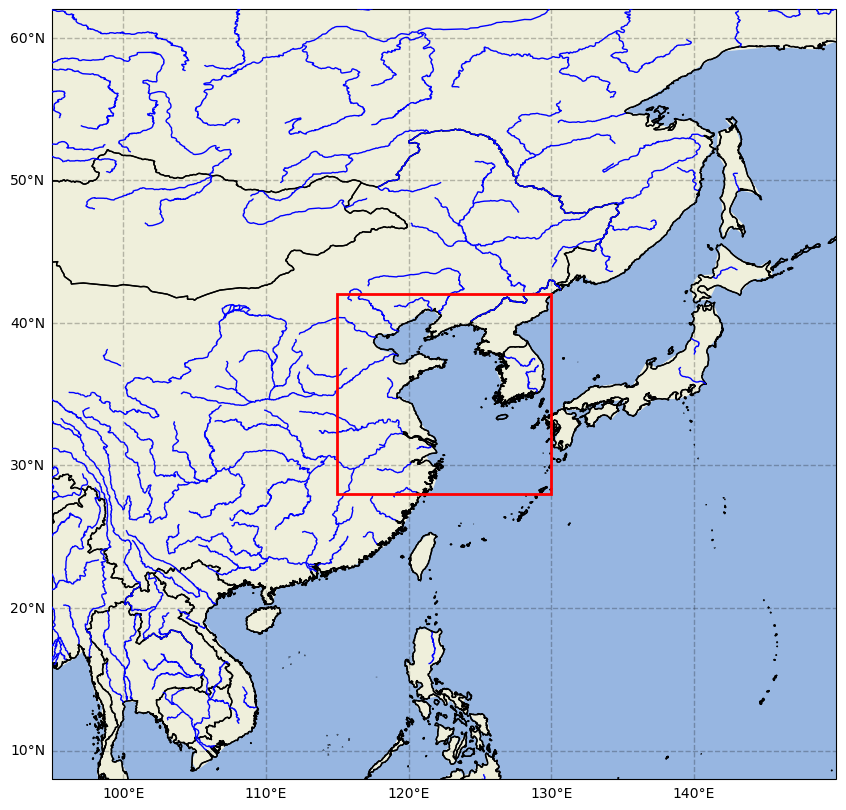

In [34]:
fishing_bb = {'min_lon': 115, 'max_lon': 130, 'min_lat': 28, 'max_lat': 42}
plotting.map_box(fishing_bb)

### Air Quality: May vs. February in the Yellow Sea 

The below graphs are a visualization of Aerosol Optical Depth (AOD) data. Aerosol Optical Depth is the measure of aerosols (e.g., urban haze, smoke. particles, desert dust) distributed within a column of air. 


### Generate Legend

In [94]:
wmsUrl = 'https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?\
SERVICE=WMS&REQUEST=GetCapabilities'

response = requests.get(wmsUrl)
WmsTree = xmlet.fromstring(response.content)

legendImg = None
for child in WmsTree.iter():
    for layer in child.findall("./{http://www.opengis.net/wms}Capability/{http://www.opengis.net/wms}Layer//*/"): 
         if layer.tag == '{http://www.opengis.net/wms}Layer': 
            f = layer.find("{http://www.opengis.net/wms}Name")
            if f is not None:
                if f.text == "MODIS_Combined_Value_Added_AOD":
                    # Style
                    e = layer.find(("{http://www.opengis.net/wms}Style/" +
                                    "{http://www.opengis.net/wms}LegendURL/" +
                                    "{http://www.opengis.net/wms}OnlineResource"))
                    legendURL = e.attrib["{http://www.w3.org/1999/xlink}href"]
                    combinedLegendImg = Image(url=legendURL)

### May (Summer and Fishing Moratorium)

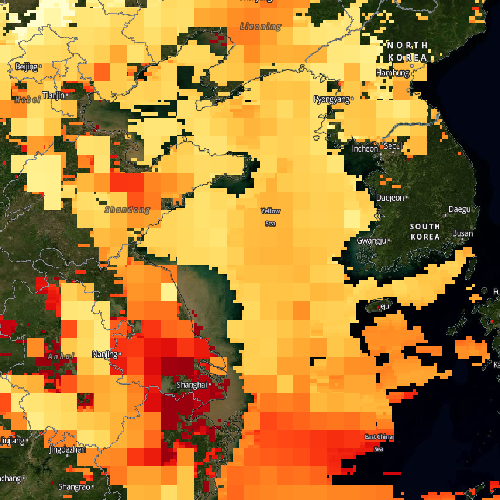

In [91]:
# TODO: add in legends, not sure this is the correct scientific conclusion could be other causes for pollution 

# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol', 
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115.179845,28.087158,130.209142,41.718570),  # Bounds (min-lon, min-lat, max-lon, max-lat) -> min lon: 115.179845, min lat: 28.087158,130.209142,41.718570
                 size=(500, 500),  # Image size
                 time='2021-05-02',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

### February (Winter and Fishing Season)

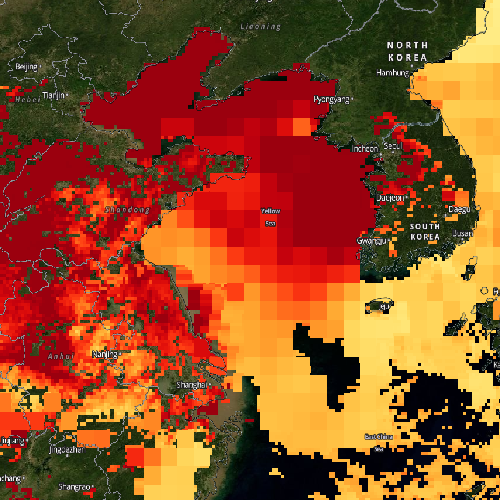

In [92]:
# Connect to GIBS WMS Service
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

img = wms.getmap(layers=['BlueMarble_NextGeneration',
                         'MODIS_Terra_Aerosol',
                         'MODIS_Aqua_Aerosol', 
                         'MODIS_Combined_Value_Added_AOD',
                         'Reference_Features',
                         'Reference_Labels'],  # Layers
                 srs='epsg:4326',  # Map projection
                 bbox=(115.179845,28.087158,130.209142,41.718570),  # Bounds (min-lon, min-lat, max-lon, max-lat)
                 size=(500, 500),  # Image size
                 time='2022-02-25',  # Time of data
                 format='image/png',  # Image format
                 transparent=True)  # Nodata transparency

# View image and legend
display(combinedLegendImg)
Image(img.read())

TODO: Add global tropomi data

# Fires and Thermal Anomalies in Southeast Asia (2022 Fire Season)
Fire season typically runs from February to April each year and is characterized by high temperatures, dry weather, and widespread agricultural burning.  

### Area of Interest

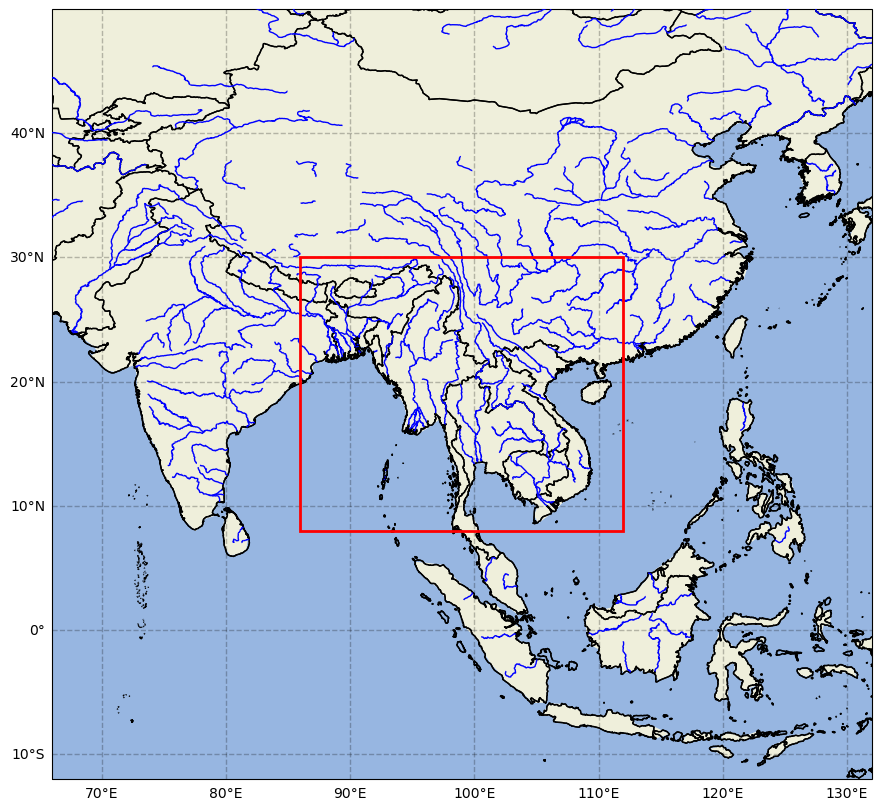

In [ ]:
anomalies_bb = {'min_lon': 86, 'max_lon': 112, 'min_lat': 8, 'max_lat': 30}
plotting.map_box(anomalies_bb)

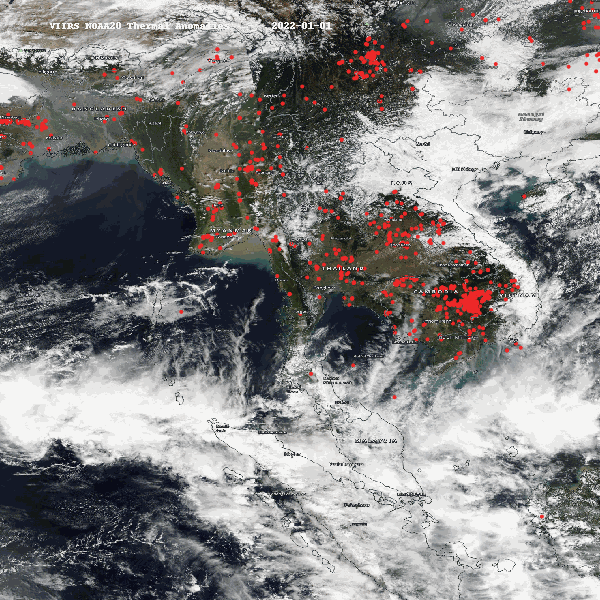

In [ ]:
wms = WebMapService('https://gibs.earthdata.nasa.gov/wms/epsg4326/best/wms.cgi?', version='1.3.0')

layers=['VIIRS_NOAA20_CorrectedReflectance_TrueColor', 
        'VIIRS_NOAA20_Thermal_Anomalies_375m_All',
        'Reference_Features',
        'Reference_Labels']
color = 'rgb(255,255,255)'
frames = []

sdate = datetime(2022, 1, 1)
edate = datetime(2022, 5, 1)
dates = pd.date_range(sdate,edate,freq='MS') 

for day in dates:
    datatime = day.strftime("%Y-%m-%d")
    img = wms.getmap(layers=layers,  # Layers
                     srs='epsg:4326',  # Map projection
                     bbox=(86, -5, 112, 31), # Bounds
                     size=(600,600),  # Image size
                     time=datatime,  # Time of data
                     format='image/png',  # Image format
                     transparent=True)  # Nodata transparency

    image = I.open(img)
    draw = ImageDraw.Draw(image)
    (x, y) = (50, 20)
    draw.text((x, y), f'VIIRS NOAA20 Thermal Anomalies   -   {datatime}', fill=color)
    frames.append(image)
    
frames[0].save('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif',
               format='GIF',
               append_images=frames,
               save_all=True,
               duration=1000,
               loop=0)

Image('VIIRS_NOAA20_Thermal_Anomalies_375m_All.gif')

TODO: Add global tropomi data